In [17]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using StatsBase

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [25]:
kmax = 3
n = 200
Z_ = rand(1:2, n)

Z = copy(Z_) 

ϑ = repeat([1.0], n)

α0 = vcat([3.0, 3.0, 20.0], [0.2, 0.7, 0.5])

# all-or-nothing cut with dyadic edges always between group
function Ω(z; α, mode = "group")
    k = (mode == "group") ? length(z) : sum(z)
    
    if k <= 2
        if mode == "group"
            if length(unique!(z)) == 1
                return (10^(-3))^(α[k])
            else 
                return length(unique!(z))^(-α[k])
            end
        elseif mode == "partition"
            if length(z) == 1
                return (10^(-3))^(α[k])
            else 
                return length(z)^(-α[k])
            end
        end
    else
        if mode == "group"
            return length(unique!(z))^(-α[k]) / n^(α[kmax+k]*k)
        elseif mode == "partition"
            return length(z)^(-α[k]) / n^(α[kmax+k]*k)
        end
    end
end

H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
H.E[1] = Dict();

In [26]:
for k = 2:kmax
    p = mean([length(partitionize(Z[e])) == 1 for e in keys(H.E[k])])
    println("k = $k: $(round(100*p, digits = 0)) % of $(length(keys(H.E[k]))) edges are within a single group.")
end

k = 2: 0.0 % of 2253 edges are within a single group.
k = 3: 100.0 % of 734 edges are within a single group.


In [27]:
cᵢ = length(H.E[3])*6/n
cₒ = length(H.E[2])*2/n

cᵢ - cₒ, sqrt(2*(cᵢ + cₒ))

(-0.5100000000000016, 9.439279633531363)

# Dyadic Modularity

In [28]:
n_rounds = 10

vL_D = zero(1.0*(1:(n_rounds+1)))
vm_D = zero((1:(n_rounds+1)))
vL_H = zero(1.0*(1:(n_rounds+1)))
K = collect(0:(n_rounds))

γ̂ = .9
α̂ = α0

timeAlg(expr)= @timed eval(expr)

println("DYADIC")

print(rpad("iteration", 12))
print(rpad("Q (dyadic)", 15))
print(rpad("L (dyadic)", 20))
print(rpad("Q (polyadic)", 15))
print(rpad("γ̂", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  100, "-"))

weighted = false

for i=1:1
    Ẑ_dyadic = copy(Z_)
    print(rpad("true", 12))
    γ̂ = computeDyadicResolutionParameter(H, Z_)
    Q = dyadicModularity(H, Z_, γ̂;weighted=weighted)
    α̂ = coordinateAscent(H, Z_, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
    ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted)
    L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out, weighted=weighted)

    Q_D = dyadicModularity(H, Z_, γ̂;weighted=weighted)

    Q_H = modularity(H, Z_, Ω; α = α̂)

    vL_D[1] = L_D
    vm_D[1] = length(unique!(Z_))
    vL_H[1] = Q_H
    
    print(rpad("$(round(Q_D, digits = 3))", 15))
    print(rpad("$(round(L_D, digits = 3))", 20))
    print(rpad("$(round(Q_H, digits = 0))", 15))
    print(rpad("$(round(γ̂, digits = 3))", 15))
    println(rpad("$(length(unique(Ẑ_dyadic)))", 10))
end
    

for i = 1:n_rounds
    out = timeAlg(:(CliqueExpansionModularity(H, γ̂, weighted, true))) # second true adds random scan order
    Ẑ_dyadic = out[1]
    time = out[2]
    
    γ̂ = computeDyadicResolutionParameter(H, Ẑ_dyadic)
    α̂ = coordinateAscent(H, Ẑ_dyadic, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
    
    Q_D = dyadicModularity(H, Ẑ_dyadic, γ̂;weighted=weighted)
    
    ω_in, ω_out = computeDyadicResolutionParameter(H, Ẑ_dyadic; mode="ω", weighted=weighted)
    L_D = dyadicLogLikelihood(H, Ẑ_dyadic, ω_in, ω_out, weighted=weighted)
    
    Q_H = modularity(H, Ẑ_dyadic, Ω; α = α̂)
    
    print(rpad("$i", 12))
    print(rpad("$(round(Q_D, digits = 3))", 15))
    print(rpad("$(round(L_D, digits = 3))", 20))
    print(rpad("$(round(Q_H, digits = 0))", 15))
    print(rpad("$(round(γ̂, digits = 3))", 15))
    print(rpad("$(length(unique(Ẑ_dyadic)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
    
    vL_D[i+1] = L_D
    vm_D[i+1] = length(unique!(Ẑ_dyadic))
    vL_H[i+1] = Q_H
    
end

DYADIC
iteration   Q (dyadic)     L (dyadic)          Q (polyadic)   γ̂             groups    time (s)  
----------------------------------------------------------------------------------------------------
true        -0.019         -9.0098020992e7     -53898.0       0.944          2         
1           0.087          -9.0097615291e7     -113949.0      1.22           6         0.027     
2           0.073          -9.0097458991e7     -103223.0      1.491          13        0.029     
3           0.064          -9.0097337117e7     -97004.0       1.815          24        0.035     
4           0.062          -9.0097301661e7     -94345.0       1.931          30        0.037     
5           0.058          -9.0097328327e7     -93712.0       2.011          35        0.026     
6           0.057          -9.009733167e7      -93356.0       2.011          36        0.029     
7           0.059          -9.009732238e7      -93158.0       1.988          34        0.023     
8           0.057   

In [41]:
round(vL_D[1]; digits = 0)

-9.0098021e7

# Polyadic Modularity

In [29]:
α0 = vcat([3.0, 0.02, 20.0], [0.2, 0.7, 0.5])

α̂  = α0

vL_H_ = zero(1.0*(1:(n_rounds)))
vm_H_ = zero((1:(n_rounds)))

println("POLYADIC")

print(rpad("iteration", 20))
print(rpad("Q", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  65, "-"))

Ẑ = zero(Z)

# α̂ = coordinateAscent(H, Z, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
# vL_H[1] = modularity(H, Z, Ω; α = α̂)
# vm_H[1] = 2

for i = 1:n_rounds
    out = timeAlg(:(SuperNodeLouvain(H,kmax,Ω;α=α̂, verbose=false, scan_order ="random")))
    Ẑ = out[1]
    time = out[2]
    
    
    α̂ = coordinateAscent(H, Ẑ, Ω, α̂; n_iters = 10, amin = -10, amax = 10)
    Q = modularity(H, Ẑ, Ω; α = α̂)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q, digits = 0))", 15))
    print(rpad("$(length(unique(Ẑ)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
    
    vL_H_[i] = Q
    vm_H_[i] = length(unique(Ẑ))
end

POLYADIC
iteration           Q              groups    time (s)  
-----------------------------------------------------------------
1                   -81308.0       40        1.301     
2                   -65363.0       4         0.544     
3                   -53898.0       2         0.301     
4                   -53898.0       2         0.294     
5                   -53898.0       2         0.324     
6                   -53898.0       2         0.318     
7                   -53898.0       2         0.351     
8                   -53898.0       2         0.339     
9                   -53898.0       2         0.315     
10                  -53898.0       2         0.333     


# Figures (trying RCall)

In [30]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 250))
R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


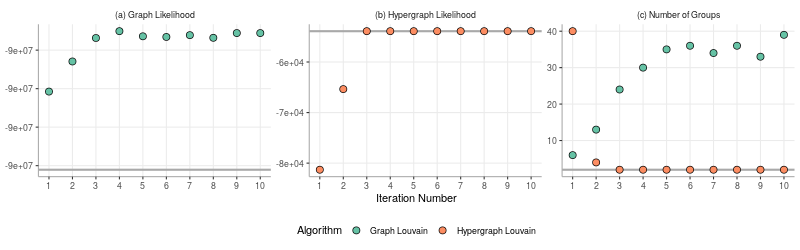

RObject{VecSxp}


In [51]:
R"""
df_dyadic <- tibble(L_D = $vL_D,  L_H = $vL_H, m = $vm_D, K = $K, Algorithm = "Graph Louvain")
df_polyadic <- tibble(L_D = NA,  L_H = $vL_H_, m = $vm_H_, K = $(1:n_rounds), Algorithm = "Hypergraph Louvain")

df <- rbind(df_dyadic, df_polyadic)

df <- df %>% 
    pivot_longer(L_D:m, names_to = "metric") %>% 
    mutate(panel = case_when(
            (metric == "L_D")&(Algorithm=="Graph Louvain")   ~ 1,
            (metric == "L_H")&((Algorithm=="Hypergraph Louvain") | (K == 0) ) ~ 2,
            (metric == "m") ~ 3
            )) %>% 
    filter(!is.na(panel))

true_df <- df %>%
    filter(K == 0)

alg_df <- df %>%
    filter(K > 0)

panel_names <- c("1" = "(a) Graph Likelihood", "2" = "(b) Hypergraph Likelihood", "3" = "(c) Number of Groups")

fancy_scientific <- function(l) {
     if(max(nchar(l), na.rm = T) < 3){return(l)}
     return(scales::label_scientific(l)(l))
}

alg_df %>% 
    ggplot() + 
    aes(x = K, y = value, fill = Algorithm) + 
    facet_wrap(~panel, scales = "free_y", labeller = as_labeller(panel_names)) + 
    geom_hline(aes(yintercept = value), data = true_df, color = "darkgrey", size = 1) + 
    geom_point(size = 3, pch = 21, color = "black") + 
    theme_bw() + 
    theme(strip.background = element_blank(),
          panel.border = element_blank(),
          axis.line = element_line(color = 'darkgrey'),
          panel.grid.minor = element_blank(),
          axis.title.y = element_blank(),
          legend.position="bottom") + 
    scale_x_continuous(breaks = 1:10, labels = 1:10) +
    scale_y_continuous(labels=fancy_scientific) + 
    scale_fill_brewer(palette = "Set2") +
    xlab("Iteration Number")
    
"""